

```
# This is formatted as code
```

# Machine Reading Models

The provided code snippet appears to be the output of the `columns` attribute of a Pandas DataFrame in Python. It lists the column names present in the DataFrame.

Here's a brief description of the columns based on their names:

- `terms`: Likely contains terms or keywords associated with each row.
- `date`: Represents the date associated with each entry.
- `sentenceIndex`: An index or identifier for each sentence.
- `sentence`: The actual text of each sentence.
- `causal`: Indicates whether the sentence contains a causal relationship.
- `causalIndex`: An index or identifier for causal relationships.
- `negationCount`: The count of negations in each sentence.
- `causeIncCount`, `causeDecCount`, `causePosCount`, `causeNegCount`: Counts related to causes, possibly indicating increase, decrease, positive, and negative aspects.
- `effectIncCount`, `effectDecCount`, `effectPosCount`, `effectNegCount`: Counts related to effects, similar to the cause counts.
- `causeText`: The text describing the cause in a causal relationship.
- `effectText`: The text describing the effect in a causal relationship.
- `belief`: Possibly indicates the belief or confidence associated with each entry.
- `sent_locs`: Locations mentioned in each sentence.
- `context_locs`: Locations mentioned in the context surrounding each sentence.
- `canonicalDate`: A standardized or canonical representation of the date.
- `prevLocation`, `prevDistance`: The previous location mentioned and its distance from the current sentence.
- `nextLocation`, `nextDistance`: The next location mentioned and its distance from the current sentence.

These column names suggest that the DataFrame contains information related to text analysis, specifically focusing on causal relationships, locations, and temporal aspects within sentences and their surrounding context.


## Skip-gram and negative sampling

In [3]:
using_colab = True
if using_colab:
  from google.colab import drive
  drive.mount ('/content/gdrive', force_remount=True)
  !pip install rasterio rasterstats fiona geopandas earthpy earthengine-api -q
  import os
  os.chdir('/content/gdrive/MyDrive/beliefs_exploration')


Mounted at /content/gdrive


In [ ]:
import gensim
import pandas as pd
from gensim.models import FastText
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import nltk
import glob

import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import pytz
import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
uganda_pdfs = pd.read_csv('uganda-pdfs.tsv',sep = '\t',index_col=0)
uganda_news = pd.read_csv('uganda.tsv',sep = '\t',index_col=0)
uganda_mining = pd.read_csv('uganda-mining.tsv',sep = '\t',index_col=0)

In [ ]:
from shapely.geometry import Point
# Create a function to parse the coordinates and create a Point object
def create_point_geometry(coordinate):
    coordinate = coordinate.replace('POINT (', '').replace(')', '')
    coordinates = coordinate.split()
    lon, lat = float(coordinates[0]), float(coordinates[1])
    return Point(lon, lat)

In [ ]:
def convert_date_formats(date_column):
    # Define the list of regex patterns for matching date formats
    date_patterns = [
        r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\+\d{2}:\d{2}',    # YYYY-MM-DDTHH:MM:SS+00:00
        r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\+\d{2}:\d{2}',    # YYYY-MM-DD HH:MM:SS+00:00
        r'[A-Za-z]+\s\d{1,2},\s\d{4}',                          # Full Month DD, YYYY (e.g., July 1, 2017)
        r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}',                  # YYYY-MM-DD HH:MM:SS
        r'[A-Za-z]+\s\d{1,2},\s\d{4}\s\d{1,2}:\d{2}\s[ap]m'     # Full Month DD, YYYY HH:MM am/pm (e.g., May 25, 2023 9:52 am)
    ]

    converted_dates = pd.Series(dtype='datetime64[ns, UTC]')

    # Iterate through each pattern and attempt to match and convert the date column
    for pattern in date_patterns:
        matches = date_column.fillna('').str.match(pattern)
        if matches.any():
            matched_dates = date_column[matches].copy()
            converted = []
            for date_str in matched_dates:
                for format_str in [
                    '%Y-%m-%dT%H:%M:%S%z',
                    '%Y-%m-%d %H:%M:%S%z',
                    '%B %d, %Y',
                    '%Y-%m-%d %H:%M:%S',
                    '%B %d, %Y %I:%M %p'
                ]:
                    try:
                        converted.append(pd.to_datetime(date_str, format=format_str, utc=True))
                        break
                    except ValueError:
                        pass
                else:
                    converted.append(pd.NaT)
            matched_dates = pd.Series(converted)
            converted_dates = pd.concat([converted_dates, matched_dates])

    # Convert to datetime and handle timezone-aware and timezone-naive values separately
    converted_dates = pd.to_datetime(converted_dates)
    if converted_dates.dt.tz is None:
        return converted_dates.dt.year
    else:
        converted_dates = converted_dates.dt.tz_convert(pytz.UTC)
        return converted_dates.dt.year

# Example usage:
year = convert_date_formats(uganda_pdfs['date'])

In [ ]:
import pandas as pd
import numpy as np

def convert_date_formats(date_series):
    date_series = pd.to_datetime(date_series, errors='coerce')
    return date_series.dt.year

uganda_pdfs['year'] = uganda_pdfs['date'].apply(lambda x: convert_date_formats(pd.Series([x])).iloc[0])

In [ ]:
uganda_pdfs.head()

,terms,date,sentenceIndex,sentence,causal,causalIndex,negationCount,causeIncCount,causeDecCount,causePosCount,...,effectText,belief,sent_locs,context_locs,canonicalDate,prevLocation,prevDistance,nextLocation,nextDistance,year
url,,,,,,,,,,,,,,,,,,,,,
https://customsearch.googleapis.com/https://www.airuniversity.af.edu/Portals/10/ACSC/curriculum/3-AY23%20AO%20Syllabus.pdf?ver=ira7MwKXzWwFMYTWmtSvgg%3D%3D,uganda,2022-09-12T23:15:59Z,0,Airpower strategy and operations .,False,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,2022-09-12T23:15:59,NaN,NaN,NaN,NaN,2022.0
https://customsearch.googleapis.com/https://www.airuniversity.af.edu/Portals/10/ACSC/curriculum/3-AY23%20AO%20Syllabus.pdf?ver=ira7MwKXzWwFMYTWmtSvgg%3D%3D,uganda,2022-09-12T23:15:59Z,1,Syllabus .,False,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,2022-09-12T23:15:59,NaN,NaN,NaN,NaN,2022.0
https://customsearch.googleapis.com/https://www.airuniversity.af.edu/Portals/10/ACSC/curriculum/3-AY23%20AO%20Syllabus.pdf?ver=ira7MwKXzWwFMYTWmtSvgg%3D%3D,uganda,2022-09-12T23:15:59Z,2,Ay 23 .,False,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,2022-09-12T23:15:59,NaN,NaN,NaN,NaN,2022.0
https://customsearch.googleapis.com/https://www.airuniversity.af.edu/Portals/10/ACSC/curriculum/3-AY23%20AO%20Syllabus.pdf?ver=ira7MwKXzWwFMYTWmtSvgg%3D%3D,uganda,2022-09-12T23:15:59Z,3,Joint professional military education .,False,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,2022-09-12T23:15:59,NaN,NaN,NaN,NaN,2022.0
https://customsearch.googleapis.com/https://www.airuniversity.af.edu/Portals/10/ACSC/curriculum/3-AY23%20AO%20Syllabus.pdf?ver=ira7MwKXzWwFMYTWmtSvgg%3D%3D,uganda,2022-09-12T23:15:59Z,4,Phase i intermediate level course .,False,NaN,NaN,NaN,NaN,NaN,...,NaN,False,NaN,NaN,2022-09-12T23:15:59,NaN,NaN,NaN,NaN,2022.0


In [ ]:
import re
import ast
from shapely.geometry import Point

def split_region_coordinates(location):
    if isinstance(location, str):
        pattern = r'(.*?)\s*\((.*?)\)'
        match = re.search(pattern, location)
        if match:
            region = match.group(1).strip()
            coordinates = match.group(2).strip()
            return region, coordinates
    return None, None

# Creating new rows based on 'sent_locs'
new_rows_list = []
for _, row in uganda_pdfs.iterrows():
    sent_locs = row['sent_locs']
    if isinstance(sent_locs, str):
        new_sent_locs = re.split(r'\s*,\s*(?![^()]*\))', sent_locs)
    else:
        new_sent_locs = [str(sent_locs)]  # Convert non-string values to strings

    new_rows = [dict(row) for _ in range(len(new_sent_locs))]
    for i, loc in enumerate(new_sent_locs):
        new_rows[i]['sent_locs'] = loc
        new_rows[i]['location'], new_rows[i]['geometry'] = split_region_coordinates(loc)

    new_rows_list.extend(new_rows)

# Creating new rows based on 'context_locs'
context_rows_list = []
for _, row in uganda_pdfs.iterrows():
    context_locs = row['context_locs']
    if isinstance(context_locs, str):
        new_context_locs = re.split(r'\s*,\s*(?![^()]*\))', context_locs)
    else:
        new_context_locs = [str(context_locs)]  # Convert non-string values to strings

    for context_loc in new_context_locs:
        if context_loc and context_loc not in [d['location'] for d in new_rows_list + context_rows_list]:
            context_location, context_coordinates = split_region_coordinates(context_loc)
            new_row = dict(row)
            new_row['context_locs'] = context_loc
            new_row['location'] = context_location
            new_row['geometry'] = context_coordinates
            context_rows_list.append(new_row)

# Concatenate all the new rows into a single DataFrame
new_rows_list.extend(context_rows_list)
uganda_pdfs = pd.DataFrame(new_rows_list)
uganda_pdfs.drop(['sent_locs', 'context_locs'], axis=1, inplace=True)

# Apply the create_point_geometry function to create true coordinates geometry
uganda_pdfs['geometry'] = uganda_pdfs['geometry'].apply(lambda x: Point(ast.literal_eval(x)) if pd.notnull(x) else None)

In [ ]:
import re
import ast
from shapely.geometry import Point

def split_region_coordinates(location):
    if isinstance(location, str):
        pattern = r'(.*?)\s*\((.*?)\)'
        match = re.search(pattern, location)
        if match:
            region = match.group(1).strip()
            coordinates = match.group(2).strip()
            return region, coordinates
    return None, None

def process_locations(locations):
    if isinstance(locations, str):
        return re.split(r'\s*,\s*(?![^()]*\))', locations)
    else:
        return [str(locations)]

# Apply the process_locations function to 'sent_locs' and 'context_locs' columns
uganda_pdfs['sent_locs'] = uganda_pdfs['sent_locs'].apply(process_locations)
uganda_pdfs['context_locs'] = uganda_pdfs['context_locs'].apply(process_locations)

# Explode the 'sent_locs' column to create new rows
uganda_pdfs = uganda_pdfs.explode('sent_locs')

# Split 'sent_locs' into 'location' and 'geometry' columns
uganda_pdfs[['location', 'geometry']] = uganda_pdfs['sent_locs'].apply(lambda x: pd.Series(split_region_coordinates(x)))

# Explode the 'context_locs' column to create new rows
context_pdfs = uganda_pdfs.explode('context_locs')

# Split 'context_locs' into 'location' and 'geometry' columns
context_pdfs[['location', 'geometry']] = context_pdfs['context_locs'].apply(lambda x: pd.Series(split_region_coordinates(x)))

# Combine the DataFrames and drop duplicate rows
uganda_pdfs = pd.concat([uganda_pdfs, context_pdfs]).drop_duplicates(subset=['location']).reset_index(drop=True)

# Drop the 'sent_locs' and 'context_locs' columns
uganda_pdfs.drop(['sent_locs', 'context_locs'], axis=1, inplace=True)

# Apply the Point geometry creation using ast.literal_eval
uganda_pdfs['geometry'] = uganda_pdfs['geometry'].apply(lambda x: Point(ast.literal_eval(x)) if pd.notnull(x) else None)

In [ ]:
import re
import ast
from shapely.geometry import Point

def split_region_coordinates(location):
    if isinstance(location, str):
        pattern = r'(.*?)\s*\((.*?)\)'
        match = re.search(pattern, location)
        if match:
            region = match.group(1).strip()
            coordinates = match.group(2).strip()
            return region, coordinates
    return None, None

def strip_quotes(coordinate):
    if isinstance(coordinate, str):
        coordinates = ast.literal_eval(coordinate)
        return coordinates
    return None

def create_point_geometry(row):
    locs_geom = row['geometry']
    if locs_geom:
        coordinates = strip_quotes(locs_geom)
        if coordinates:
            longitude, latitude = map(float, coordinates)
            return Point(longitude, latitude)
    return None

# Creating new rows based on 'sent_locs'
new_rows_list = []
for i in range(uganda_pdfs.shape[0]):
    sent_locs = uganda_pdfs.sent_locs.iloc[i]
    if isinstance(sent_locs, str):
        new_sent_locs = re.split(r'\s*,\s*(?![^()]*\))', sent_locs)
    else:
        new_sent_locs = [str(sent_locs)]  # Convert non-string values to strings
    orig_row = uganda_pdfs.iloc[i]
    new_rows = pd.DataFrame([orig_row] * len(new_sent_locs), columns=uganda_pdfs.columns)
    new_rows['sent_locs'] = new_sent_locs
    new_rows['location'] = [split_region_coordinates(loc)[0] for loc in new_sent_locs]
    new_rows['geometry'] = [split_region_coordinates(loc)[1] for loc in new_sent_locs]
    new_rows.drop('sent_locs', axis=1, inplace=True)
    new_rows_list.append(new_rows)

# Creating new rows based on 'context_locs'
for i in range(uganda_pdfs.shape[0]):
    context_locs = uganda_pdfs.context_locs.iloc[i]
    if isinstance(context_locs, str):
        new_context_locs = re.split(r'\s*,\s*(?![^()]*\))', context_locs)
    else:
        new_context_locs = [str(context_locs)]  # Convert non-string values to strings
    for context_loc in new_context_locs:
        if context_loc and not any(context_loc in df['location'].values for df in new_rows_list):
            context_location, context_coordinates = split_region_coordinates(context_loc)
            new_row = uganda_pdfs.iloc[i].copy()
            new_row['context_locs'] = context_loc
            new_row['location'] = context_location
            new_row['geometry'] = context_coordinates
            new_rows_list.append(pd.DataFrame([new_row]))

# Concatenate all the new rows into a single DataFrame
uganda_pdfs = pd.concat(new_rows_list, ignore_index=True)
uganda_pdfs.drop(['sent_locs', 'context_locs'], axis=1, inplace=True)

# Apply the create_point_geometry function to create true coordinates geometry
uganda_pdfs['geometry'] = uganda_pdfs.apply(create_point_geometry, axis=1)

In [ ]:
uganda_pdfs.columns

Index(['terms', 'date', 'sentenceIndex', 'sentence', 'causal', 'causalIndex',
       'negationCount', 'causeIncCount', 'causeDecCount', 'causePosCount',
       'causeNegCount', 'effectIncCount', 'effectDecCount', 'effectPosCount',
       'effectNegCount', 'causeText', 'effectText', 'belief', 'sent_locs',
       'context_locs', 'canonicalDate', 'prevLocation', 'prevDistance',
       'nextLocation', 'nextDistance', 'year'],
      dtype='object')

In [ ]:
uganda_pdfs.sent_locs.unique()

array([nan, 'Uganda (1.25, 32.5)', 'Karamoja (2.53453, 34.66659)', ...,
       'Apeitolim (2.46979, 33.75824)',
       'Lukaya (-0.11306, 31.85389), Masaka (0.08185, 32.24279)',
       'Kasese (0.18333, 30.08333), Mubende (1.65328, 31.58528)'],
      dtype=object)

In [ ]:
new_rows_list[510]

,terms,date,sentenceIndex,sentence,causal,causalIndex,negationCount,causeIncCount,causeDecCount,causePosCount,...,belief,context_locs,canonicalDate,prevLocation,prevDistance,nextLocation,nextDistance,year,location,geometry
https://customsearch.googleapis.com/https://www.airuniversity.af.edu/Portals/10/ACSC/curriculum/3-AY23%20AO%20Syllabus.pdf?ver=ira7MwKXzWwFMYTWmtSvgg%3D%3D,uganda,2022-09-12T23:15:59Z,503,[El] .,False,NaN,NaN,NaN,NaN,NaN,...,False,NaN,2022-09-12T23:15:59,NaN,NaN,NaN,NaN,2022.0,None,None


In [ ]:
uganda_pdfs.to_csv('uganda_pdfs.csv')

In [ ]:
#Creating new rows based on 'sent_locs'
for i in range(uganda_pdfs.shape[0]):
    new_sent_locs = re.split(r'\s*,\s*(?![^()]*\))', uganda_pdfs.sent_locs.iloc[i])
    orig_row = uganda_pdfs.iloc[i]
    new_rows = pd.DataFrame([orig_row] * len(new_sent_locs), columns=extracted.columns)
    new_rows['sent_locs'] = new_sent_locs
    new_rows['location'] = [split_region_coordinates(new_sent_locs[j])[0] for j in range(len(new_sent_locs))]
    new_rows['geometry'] = [split_region_coordinates(new_sent_locs[j])[1] for j in range(len(new_sent_locs))]
    new_rows.drop('sent_locs', axis=1, inplace=True)
    new_context_locs = re.split(r'\s*,\s*(?![^()]*\))', uganda_pdfs.context_locs.iloc[i])

    # Creating new rows based on 'context_locs'
    for j in range(len(new_context_locs)):
        context_loc = new_context_locs[j]

        # Check if the location already exists in the DataFrame
        if not any(df['location'] == context_loc):
            context_location = split_region_coordinates(context_loc)[0]
            context_coordinates = split_region_coordinates(context_loc)[1]

            # Append a new row with the context location
            new_row = new_rows.iloc[0].copy()
            new_row['context_locs'] = context_loc
            new_row['location'] = context_location
            new_row['geometry'] = context_coordinates
            df = df.append(new_row, ignore_index=True)
            df.drop('context_locs', axis=1, inplace=True)

def strip_quotes(coordinate):
    coordinates = ast.literal_eval(coordinate)
    return coordinates

# Function to create a Point geometry from coordinates
def create_point_geometry(row):
    locs_geom = row['geometry']
    if locs_geom:
        longitude, latitude = map(float, strip_quotes(locs_geom))
        return Point(longitude, latitude)
    else:
        return None

# # Apply the create_point_geometry function to create true coordinates geometry
uganda_pdfs['geometry'] = uganda_pdfs.apply(create_point_geometry, axis=1)

In [ ]:
# Define the directory path where the TSV files are located
directory = '/content/drive/MyDrive/HEURISTICS/Ghana_predictions/Beliefs/ghana_beliefs/'

# Get the file paths of all TSV files in the directory
tsv_files = glob.glob(directory + '*.tsv')

# Create an empty list to store the DataFrames
dataframes = []

# Read each TSV file and append its DataFrame to the list
for file in tsv_files:
    df = pd.read_csv(file, delimiter='\t',index_col=0)


    df = df.dropna()
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes)
#combined_df['belief_resolved'] =  combined_df['belief_resolved'].replace({'</b>': '', '.': '', '<br>': ''}, regex=True)

# Print the combined DataFrame
combined_df.head(3)


,belief,belief_resolved,title,url,date,byline,context,sentiment_score,similarity_score,sent_locs,context_locs
2,"Mining artisans, popularly known as ‘galamseye...","Mining artisans, popularly known as ‘galamseye...",Tension in Wawase-Obuasi as artisans clash wit...,https://3news.com/tension-in-wawase-obuasi-as-...,2022-03-18 13:54:43,Emmanuel Kwame Amoh,But for the timely intervention of a joint pol...,0.000000,0.466794,"Ashanti Region (6.75, -1.5), Wawase (6.9329, -...","Ashanti Region (6.75, -1.5), Obuasi (6.21128, ..."
3,It is the exposure I had in this last campaign...,Addressing the Ghanaian community resident in ...,Alternative sources of livelihood for ‘galamse...,https://www.etvghana.com/alternative-sources-o...,2017-05-22T08:58:17+00:00,None,"According to President Akufo-Addo, a cabinet c...",0.995186,0.465967,"Elmina (5.0847, -1.35093)","Elmina (5.0847, -1.35093), Ghana (8.1, -1.2)"
9,We believe that the capacities of these youth ...,We believe that the capacities of these youth ...,Galamsey on top of agenda for Lands Minister n...,https://citifmonline.com/2017/01/galamsey-on-t...,"January 12, 2017",Anita Arthur/citibusinessnews.com/Ghana,The informal activities have caused damage to ...,0.991854,0.414734,"Ghana (8.1, -1.2)","Ghana (8.1, -1.2)"


In [ ]:
combined_df.isnull().sum()

belief              0
belief_resolved     0
title               0
url                 0
date                0
byline              0
context             0
sentiment_score     0
similarity_score    0
sent_locs           0
context_locs        0
dtype: int64

In [ ]:
#nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in combined_df['belief_resolved'])

In [ ]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))


Time to clean up everything: 0.05 mins


In [ ]:
combined_df.belief_resolved.iloc[2]

'We believe that the capacities of these youth involved in these activities have to be built for them to conduct their mining activities in a more sustainable way.”  Foreign residents in Ghana particularly Chinese have been identified as one of the key categories of perpetrators of the galamsey menace.'

In [ ]:
combined_df.shape

(689, 11)

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/HEURISTICS_shared_work/Ghana /Data/Beliefs/ranked_resolved_with_sentiment_with_location_convert_update/original_data/ranked_beliefs_for_query-fear-scared-frightened-concern-galamsey-mining-with-loc.tsv',sep = '\t',index_col =0)
# df = df.dropna()
# df.head(10)
#

In [ ]:
import pandas as pd
beliefs = pd.read_csv("/content/drive/MyDrive/HEURISTICS/Ghana_predictions/Beliefs/ranked_beliefs_combined.csv",index_col=0)

In [ ]:
# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = combined_df['belief_resolved'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences #splitting the words in a sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Train the Word2Vec model
model = Word2Vec(tokenized_sentences, vector_size=689, window=5, min_count=1)

# Get the word embeddings  #numerical representation
word_embeddings = model.wv

# Calculate the polarity of words # similarity
polarity = word_embeddings['positive'] - word_embeddings['negative']

# Example usage: Get the embedding vector for a specific word and calculate polarity
embedding_vector = word_embeddings['love']
word_polarity = embedding_vector - polarity

# Print the polarity of the word
print(word_polarity)

[-3.59143019e-02  1.29583515e-02 -3.68198976e-02  2.93730237e-02
 -4.60953265e-02 -5.28778955e-02  7.89968967e-02  4.31998074e-02
 -1.68616660e-02 -8.07178095e-02 -3.30264196e-02 -2.38988642e-02
 -6.96925223e-02  1.46069080e-02 -2.67167725e-02 -2.97858827e-02
  1.77559126e-02 -4.88631651e-02 -2.57004127e-02 -2.45872326e-02
  7.15742353e-03  7.05006812e-03  5.09243906e-02 -3.54758203e-02
 -3.45190577e-02 -1.63386427e-02  9.71228033e-02  5.84065914e-02
 -1.60891302e-02 -2.01800130e-02 -1.87622420e-02  1.52704474e-02
  6.81830421e-02 -9.42947417e-02 -3.70496437e-02 -6.42779991e-02
  1.17522284e-01 -6.37585521e-02  7.18267411e-02 -9.55785252e-03
  5.98897506e-03 -1.55614559e-02  4.40330133e-02  2.55598277e-02
  7.99870640e-02 -3.12510915e-02 -4.17900048e-02  5.05424803e-03
  2.58421525e-02 -2.09953394e-02  4.63513471e-02  2.86332313e-02
 -1.91322789e-02  3.58966962e-02 -3.59854624e-02 -4.98308167e-02
 -1.17425919e-02 -1.98441744e-02 -1.98219493e-02  4.38693203e-02
  3.47878858e-02 -1.50313

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = combined_df['belief_resolved'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Train the Word2Vec model
model = Word2Vec(tokenized_sentences, vector_size=689, window=5, min_count=1)

# Get the word embeddings
word_embeddings = model.wv

# Calculate similarity between words in the sentences
target_word = 'illegal'  # The word you want to compare with other words in the sentences

for sentence in tokenized_sentences:
    similarity_scores = []
    for word in sentence:
        print(word)
        similarity_score = model.wv.similarity(target_word, word)
        similarity_scores.append((word, similarity_score))

    # Sort the similarity scores in descending order
    similarity_scores.sort(key=lambda x: x[1], reverse=True)

    print("Sentence:", ' '.join(sentence))
    print("Similarity Scores:")
    for word, score in similarity_scores:
        print(f"{word}: {score}")
    print()


Streaming output truncated to the last 5000 lines.
the: 0.9999251365661621
,: 0.9999199509620667
,: 0.9999199509620667
at: 0.9999199509620667
,: 0.9999199509620667
and: 0.9999191164970398
has: 0.999914824962616
that: 0.9999145865440369
is: 0.9999144077301025
his: 0.9999135136604309
his: 0.9999135136604309
.: 0.999910831451416
region: 0.999894917011261
nana: 0.9998842477798462
minister: 0.9998746514320374
president: 0.9998627305030823
akufo-addo: 0.9998499155044556
traditional: 0.9998481273651123
under: 0.9998401999473572
kyebi: 0.9998342990875244
kyebi: 0.9998342990875244
former: 0.9998262524604797
kwabena: 0.999823272228241
eastern: 0.9997953772544861
environment: 0.9997879266738892
's: 0.9997783899307251
back: 0.9997422695159912
council: 0.9997300505638123
technology: 0.999694287776947
must: 0.999686598777771
going: 0.9995953440666199
science: 0.9994857907295227
frimpong-boateng: 0.9993835091590881
right: 0.9981111884117126
residence: 0.9978117346763611
innovation: 0.9977324604988098

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = combined_df['belief_resolved'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Filter out stop words and unwanted expressions
stop_words = set(stopwords.words('english'))
unwanted_words = ['of', 'in', 'because', ',', 'and', 'on','the','.',')','(','ghana','ghanaians','by','a','!','“”','>','<','b','/b','’','mr',
                  'dr.','said','[]']  # Add any other unwanted words or expressions
filtered_sentences = [
    [word for word in sentence if word not in stop_words and word not in unwanted_words]
    for sentence in tokenized_sentences
]

# Train the Word2Vec model
model = Word2Vec(filtered_sentences, vector_size=689, window=5, min_count=1)

# Get the word embeddings
word_embeddings = model.wv

# Calculate similarity between words in the sentences
target_word = 'illegal'  # The word you want to compare with other words in the sentences

for sentence in filtered_sentences:
    similarity_scores = []
    for word in sentence:
        similarity_score = model.wv.similarity(target_word, word)
        similarity_scores.append((word, similarity_score))

    # Sort the similarity scores in descending order
    similarity_scores.sort(key=lambda x: x[1], reverse=True)

    print("Sentence:", ' '.join(sentence))
    print("Similarity Scores:")
    for word, score in similarity_scores:
        print(f"{word}: {score}")
    print()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Streaming output truncated to the last 5000 lines.
north: 0.3285963833332062
following: 0.2993650734424591
without: 0.2873933017253876
queen: 0.2265014499425888
permission: 0.11587392538785934
bad: 0.09706013649702072
appiah-kubi: 0.08821196854114532
re-entry: 0.07868330925703049
andy: 0.06215469539165497
asante-akim: 0.042912088334560394

Sentence: stressed time come wash sector commit financial resources technical support prisons police detaining cells
Similarity Scores:
resources: 0.6549981832504272
police: 0.6343479156494141
support: 0.5395471453666687
sector: 0.48010241985321045
come: 0.47845929861068726
time: 0.3170155882835388
stressed: 0.3039008378982544
technical: 0.10236628353595734
wash: 0.08253150433301926
financial: 0.08151059597730637
cells: 0.04645436257123947
detaining: 0.03197108581662178
prisons: -0.00015369376342277974
commit: -0.025065811350941658

Sentence: younger generation might heard likes raymond kwame amankwah alleged attended victory celebration 2020 electio

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = combined_df['belief_resolved'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Filter out stop words and unwanted expressions
stop_words = set(stopwords.words('english'))
unwanted_words = ['of', 'in', 'because', ',', 'and', 'on', 'the', '.', ')', '(', 'ghana', 'ghanaians', 'by', 'a', '!', '“”', '>', '<', 'b', '/b', '’', 'mr', 'dr.', 'said', '[]']
filtered_sentences = [
    [word for word in sentence if word not in stop_words and word not in unwanted_words]
    for sentence in tokenized_sentences
]

# Train the Word2Vec model
model = Word2Vec(filtered_sentences, vector_size=689, window=5, min_count=1)

# Get the word embeddings
word_embeddings = model.wv

# Calculate polarity of all words
polarity_scores = {}
target_word = 'illegal'  # The word you want to compare with other words in the sentences

for sentence in filtered_sentences:
    for word in sentence:
        if word not in polarity_scores:
            similarity_score = model.wv.similarity(target_word, word)
            polarity_scores[word] = similarity_score

# Sort the words based on polarity scores
sorted_words = sorted(polarity_scores.items(), key=lambda x: x[1], reverse=True)

# Print the words and their polarity scores
for word, score in sorted_words:
    print(f"{word}: {score}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


illegal: 0.9999999403953552
mining: 0.8041603565216064
”: 0.7798982262611389
galamsey: 0.768901526927948
“: 0.7468357086181641
government: 0.7459354400634766
country: 0.7401731610298157
region: 0.7387531995773315
president: 0.7222073674201965
water: 0.7105132341384888
china: 0.7078314423561096
also: 0.705424964427948
expressed: 0.6973605155944824
people: 0.695224404335022
would: 0.6874786615371704
district: 0.6860381364822388
miners: 0.6860321164131165
accra: 0.6751223802566528
national: 0.6743579506874084
ashanti: 0.6703684329986572
fight: 0.6662864089012146
resources: 0.6557176113128662
gold: 0.65302973985672
minister: 0.6487066149711609
activities: 0.6432595252990723
cocoa: 0.6421719193458557
–: 0.640171468257904
western: 0.635837197303772
police: 0.632649838924408
chinese: 0.6301561594009399
nana: 0.6264098286628723
one: 0.6252013444900513
eastern: 0.6186612248420715
environment: 0.6153709292411804
gna: 0.6082677245140076
bodies: 0.6019434928894043
akufo-addo: 0.6018202304840088
ar

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


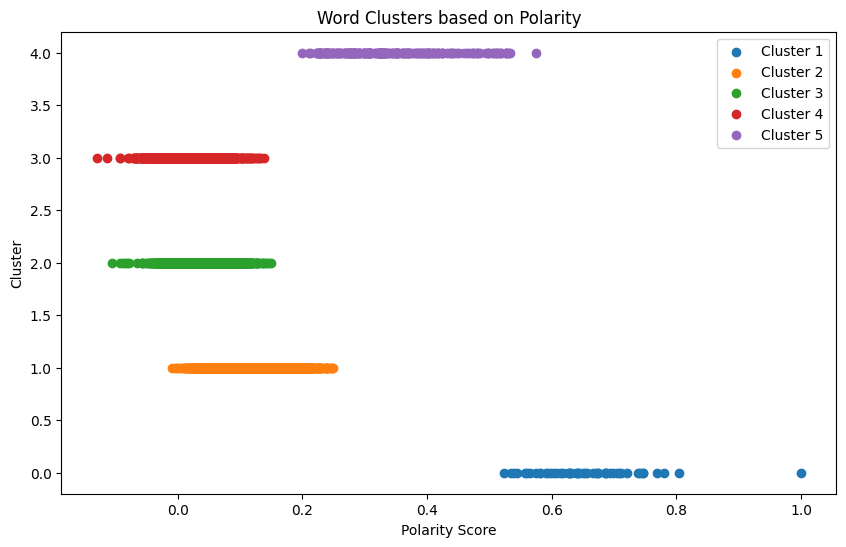

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import nltk

nltk.download('stopwords')

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = combined_df['belief_resolved'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Filter out stop words and unwanted expressions
stop_words = set(stopwords.words('english'))
unwanted_words = ['of', 'in', 'because', ',', 'and', 'on', 'the', '.', ')', '(', 'ghana', 'ghanaians', 'by', 'a', '!', '“”', '>', '<', 'b', '/b', '’', 'mr', 'dr.', 'said', '[]']
filtered_sentences = [
    [word for word in sentence if word not in stop_words and word not in unwanted_words]
    for sentence in tokenized_sentences
]

# Train the Word2Vec model
model = Word2Vec(filtered_sentences, vector_size=689, window=5, min_count=1)

# Get the word embeddings
word_embeddings = model.wv

# Calculate polarity of all words
polarity_scores = {}
target_word = 'illegal'  # The word you want to compare with other words in the sentences

for sentence in filtered_sentences:
    for word in sentence:
        if word not in polarity_scores:
            similarity_score = model.wv.similarity(target_word, word)
            polarity_scores[word] = similarity_score

# Convert word embeddings and polarity scores to arrays
word_vectors = np.array([word_embeddings[word] for word in polarity_scores])
polarity_values = np.array(list(polarity_scores.values())).reshape(-1, 1)

# Cluster the word vectors
num_clusters = 5  # Adjust the number of clusters as desired
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(word_vectors)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_words = np.array(list(polarity_scores.keys()))[clusters == i]
    x = polarity_values[clusters == i]
    y = np.ones_like(x) * i
    plt.scatter(x, y, label=f'Cluster {i + 1}')

plt.xlabel('Polarity Score')
plt.ylabel('Cluster')
plt.title('Word Clusters based on Polarity')
plt.legend()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


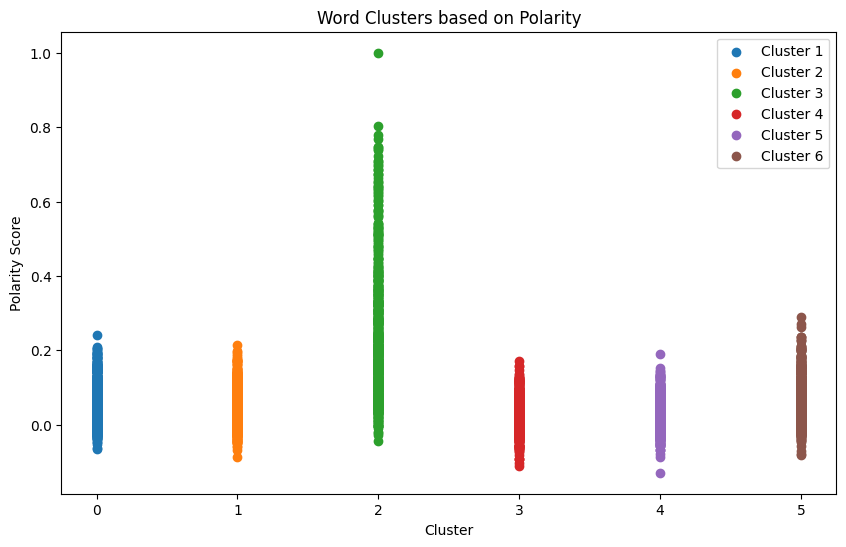

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import nltk

nltk.download('stopwords')

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = combined_df['belief_resolved'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Filter out stop words and unwanted expressions
stop_words = set(stopwords.words('english'))
unwanted_words = ['of', 'in', 'because', ',', 'and', 'on', 'the', '.', ')', '(', 'ghana', 'ghanaians', 'by', 'a', '!', '“”', '>', '<', 'b', '/b', '’', 'mr', 'dr.', 'said', '[]']
filtered_sentences = [
    [word for word in sentence if word not in stop_words and word not in unwanted_words]
    for sentence in tokenized_sentences
]

# Train the Word2Vec model
model = Word2Vec(filtered_sentences, vector_size=689, window=5, min_count=1)

# Get the word embeddings
word_embeddings = model.wv

# Calculate polarity of all words
polarity_scores = {}
target_word = 'illegal'  # The word you want to compare with other words in the sentences

for sentence in filtered_sentences:
    for word in sentence:
        if word not in polarity_scores:
            similarity_score = model.wv.similarity(target_word, word)
            polarity_scores[word] = similarity_score

# Convert word embeddings and polarity scores to arrays
word_vectors = np.array([word_embeddings[word] for word in polarity_scores])
polarity_values = np.array(list(polarity_scores.values())).reshape(-1, 1)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
word_vectors_tsne = tsne.fit_transform(word_vectors)

# Cluster the word vectors
num_clusters = 6  # Adjust the number of clusters as desired
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(word_vectors_tsne)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_words = np.array(list(polarity_scores.keys()))[clusters == i]
    y = polarity_values[clusters == i]
    x = np.ones_like(y) * i
    plt.scatter(x, y, label=f'Cluster {i + 1}')

plt.xlabel('Cluster')
plt.ylabel('Polarity Score')
plt.title('Word Clusters based on Polarity')
plt.legend()
plt.show()


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import nltk
from wordcloud import WordCloud

nltk.download('stopwords')

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = combined_df['belief_resolved'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Filter out stop words and unwanted expressions
stop_words = set(stopwords.words('english'))
unwanted_words = ['of', 'in', 'because', ',', 'and', 'on', 'the', '.', ')', '(', 'ghana', 'ghanaians', 'by', 'a', '!', '“”', '>', '<', 'b', '/b', '’', 'mr', 'dr.', 'said', '[]']
filtered_sentences = [
    [word for word in sentence if word not in stop_words and word not in unwanted_words]
    for sentence in tokenized_sentences
]

# Train the Word2Vec model
model = Word2Vec(filtered_sentences, vector_size=689, window=5, min_count=1)

# Get the word embeddings
word_embeddings = model.wv

# Calculate polarity of all words
polarity_scores = {}
target_word = 'illegal'  # The word you want to compare with other words in the sentences

for sentence in filtered_sentences:
    for word in sentence:
        if word not in polarity_scores:
            similarity_score = model.wv.similarity(target_word, word)
            polarity_scores[word] = similarity_score

# Convert word embeddings and polarity scores to arrays
word_vectors = np.array([word_embeddings[word] for word in polarity_scores])
polarity_values = np.array(list(polarity_scores.values())).reshape(-1, 1)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
word_vectors_tsne = tsne.fit_transform(word_vectors)

# Cluster the word vectors
num_clusters = 5 # Adjust the number of clusters as desired
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(word_vectors_tsne)

# Generate word cloud for each cluster
wordclouds = []
for i in range(num_clusters):
    cluster_words = np.array(list(polarity_scores.keys()))[clusters == i]
    wordcloud_text = ' '.join(cluster_words)
    wordcloud = WordCloud(width=800, height=400).generate(wordcloud_text)
    wordclouds.append((i, wordcloud))

# Plot the clusters and word clouds
fig, axes = plt.subplots(num_clusters, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.imshow(wordclouds[i][1], interpolation='bilinear')
    ax.set_title(f'Cluster {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


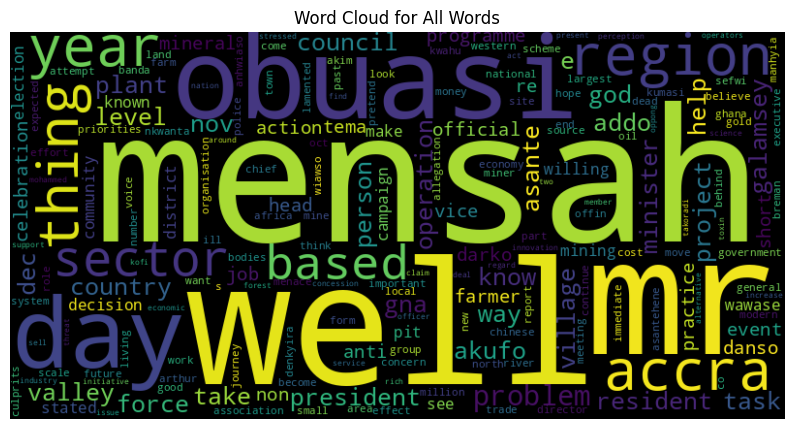

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import nltk
from wordcloud import WordCloud

nltk.download('stopwords')

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = combined_df['belief_resolved'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Filter out stop words and unwanted expressions
stop_words = set(stopwords.words('english'))
unwanted_words = ['of', 'in', 'because', ',', 'and', 'on', 'the', '.', ')', '(', 'ghana', 'ghanaians', 'by', 'a', '!', '“”', '>', '<', 'b', '/b', '’', 'mr', 'dr.', 'said', '[]']
filtered_sentences = [
    [word for word in sentence if word not in stop_words and word not in unwanted_words]
    for sentence in tokenized_sentences
]

# Train the Word2Vec model
model = Word2Vec(filtered_sentences, vector_size=689, window=5, min_count=1)

# Get the word embeddings
word_embeddings = model.wv

# Calculate polarity of all words
polarity_scores = {}
target_word = 'illegal'  # The word you want to compare with other words in the sentences

for sentence in filtered_sentences:
    for word in sentence:
        if word not in polarity_scores:
            similarity_score = model.wv.similarity(target_word, word)
            polarity_scores[word] = similarity_score

# Generate word cloud for all words
wordcloud_text = ' '.join(polarity_scores.keys())
wordcloud = WordCloud(width=800, height=400).generate(wordcloud_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Words')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


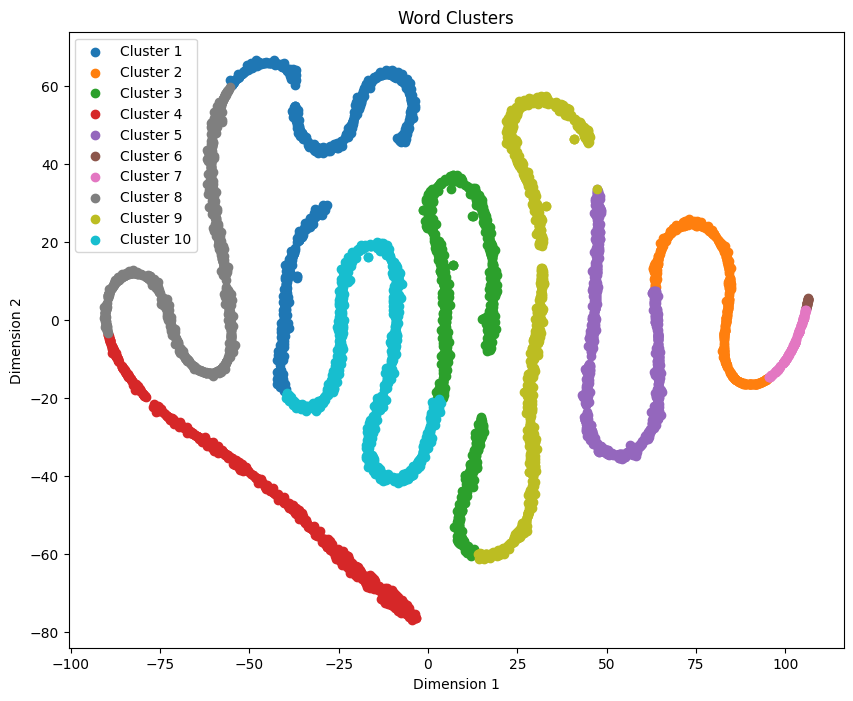

In [ ]:

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = df2['just_belief'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Build Word Embeddings using FastText
model = FastText(sentences=tokenized_sentences, window=5, min_count=1, workers=4)

# Step 4: Access Word Embeddings
word_embeddings = model.wv

# Step 5: Calculate similarity matrix
similarity_matrix = np.dot(word_embeddings.vectors, word_embeddings.vectors.T)

# Step 6: Apply clustering algorithm
num_clusters = 10  # Number of clusters to create
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)

# Step 7: Visualize the clusters using t-SNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(word_embeddings.vectors)

# Step 8: Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster_embeddings = tsne_embeddings[clusters == i]
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], label=f'Cluster {i+1}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Clusters')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


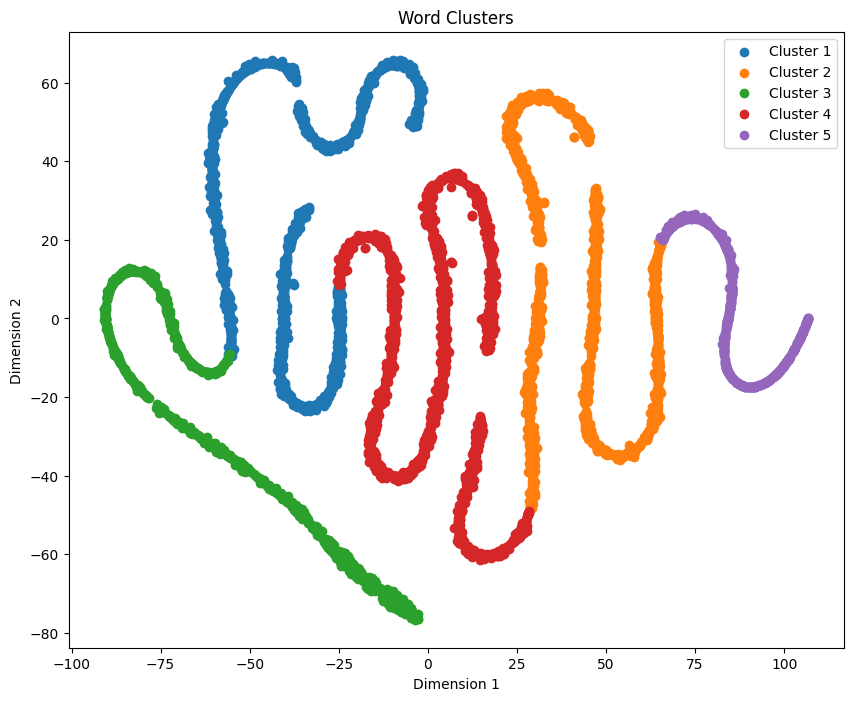

In [ ]:
# Step 6: Apply clustering algorithm
num_clusters = 5  # Number of clusters to create
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)

# Step 7: Visualize the clusters using t-SNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(word_embeddings.vectors)

# Step 8: Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster_embeddings = tsne_embeddings[clusters == i]
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], label=f'Cluster {i+1}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Clusters')
plt.legend()
plt.show()

In [ ]:
pip install line_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.9/661.9 kB 10.6 MB/s eta 0:00:00


In [ ]:
from itertools import zip_longest
from bisect import insort
from itertools import zip_longest
from bisect import insort
from joblib import Parallel, delayed
import line_profiler

profile = line_profiler.LineProfiler()

lemmas = ["Do", "dOne", "PUrpose", "can", "be", "use", "for", "cannon", "amuse", "useful", "user", "become", "downtown", "develop", "fulminate", "deduce", "de", "bezant"]
forms = ["doNE", "donE", "doIng", "purposeful", "canonical", "becareful", "being", "berate", "best", "bezant", "full", "fulmination", "predict", "downgrade", "down", "developing", "deduct", "deducing"]
distances = {}


@delayed
def calc_distances(form, lemmas_low):
    form_distances = []
    for lemma in lemmas_low:
        char_matches = [c1 != c2 for c1, c2 in zip_longest(lemma, form)]
        dist = 1 - (sum(char_matches)/len(char_matches))
        if dist > 0.25:
            insort(form_distances, (dist, lemma))
    return (form, form_distances)
@profile
def profile_distance_calcs():
    lemmas_low = [lemma.lower() for lemma in lemmas]
    forms_low = [form.lower() for form in forms]
    for form in forms_low:
        form_distances = []
        for lemma in lemmas_low:
            char_matches = [c1 != c2 for c1, c2 in zip_longest(lemma, form)]
            dist = 1 - (sum(char_matches)/len(char_matches))
            if dist > 0.25:
                insort(form_distances, (dist, lemma))
        distances[form] = form_distances

    with open("potential_lemmas_hamming.txt", "w") as f:
        for form, form_distances in distances.items():
            for dist, lemma in reversed(form_distances[-2:]):
                f.write(f"{form} ➝  {lemma}: {dist}\n")

if __name__ == "__main__":
    profile_distance_calcs()

In [ ]:
pip install textdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from textdistance import hamming, cosine, jaro_winkler
import heapq

lemmas = ["do", "done", "purpose", "can", "be", "use", "for", "cannon", "amuse", "useful", "user", "become", "downtown", "develop", "fulminate", "deduce", "de", "bezant"]
forms = ["done", "done", "doing", "purposeful", "canonical", "becareful", "being", "berate", "best", "bezant", "full", "fulmination", "predict", "downgrade", "down", "developing", "deduct", "deducing"]
distances = {}
processed_pairs = set() # keep track of processed pairs

@profile
def profile_distance_calcs():
    for lemma in lemmas:
        if lemma is None:
            continue
        lemma_lower = lemma.lower()
        for form in forms:
            if form is None:
                continue
            form_lower = form.lower()
            pair = (lemma_lower, form_lower)
            if pair not in processed_pairs:
                processed_pairs.add(pair)
                dist = hamming.normalized_similarity(lemma_lower, form_lower)
                if dist > 0.25:
                    distances.setdefault(form_lower, []).append((dist, lemma_lower))

    # Find the closest pairs
    closest_pairs = {}
    for form, dist_lemmas in distances.items():
        closest_pairs[form] = heapq.nlargest(2, dist_lemmas)

    with open("potential_lemmas_orig.txt", "w") as f:
        for form, pairs in closest_pairs.items():
            for dist, lemma in pairs:
                f.write(f"{form} ➝  {lemma}: {dist}\n")

if __name__ == "__main__":
    profile_distance_calcs()

In [ ]:
heapq.nlargest

<function heapq.nlargest(n, iterable, key=None)>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


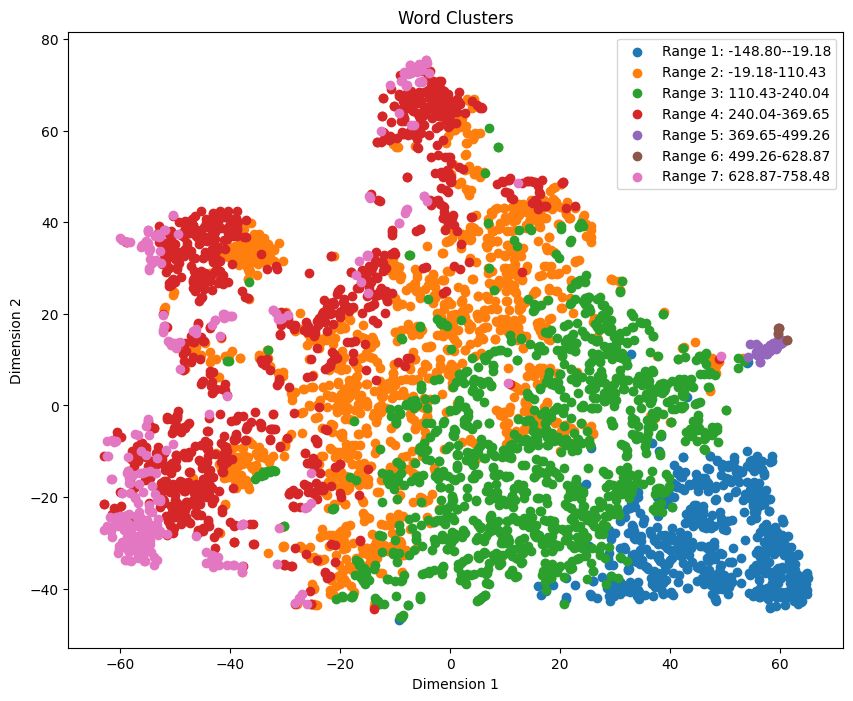

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from gensim.models import FastText
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = beliefs['belief'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Build Word Embeddings using FastText
model = FastText(sentences=tokenized_sentences, window=5, min_count=1, workers=4)

# Step 4: Access Word Embeddings
word_embeddings = model.wv

# Step 5: Calculate similarity matrix
similarity_matrix = np.dot(word_embeddings.vectors, word_embeddings.vectors.T)

# Step 6: Apply clustering algorithm
num_clusters = 7  # Number of clusters to create
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)

# Step 7: Get similarity matrix value ranges
similarity_ranges = np.linspace(np.min(similarity_matrix), np.max(similarity_matrix), num_clusters + 1)

# Step 8: Visualize the clusters using t-SNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(word_embeddings.vectors)

# Step 9: Plot the clusters with similarity matrix value ranges as labels
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster_embeddings = tsne_embeddings[clusters == i]
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], label=f'Range {i+1}: {similarity_ranges[i]:.2f}-{similarity_ranges[i+1]:.2f}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Clusters')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-31-b66896cbd088>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', num_clusters)


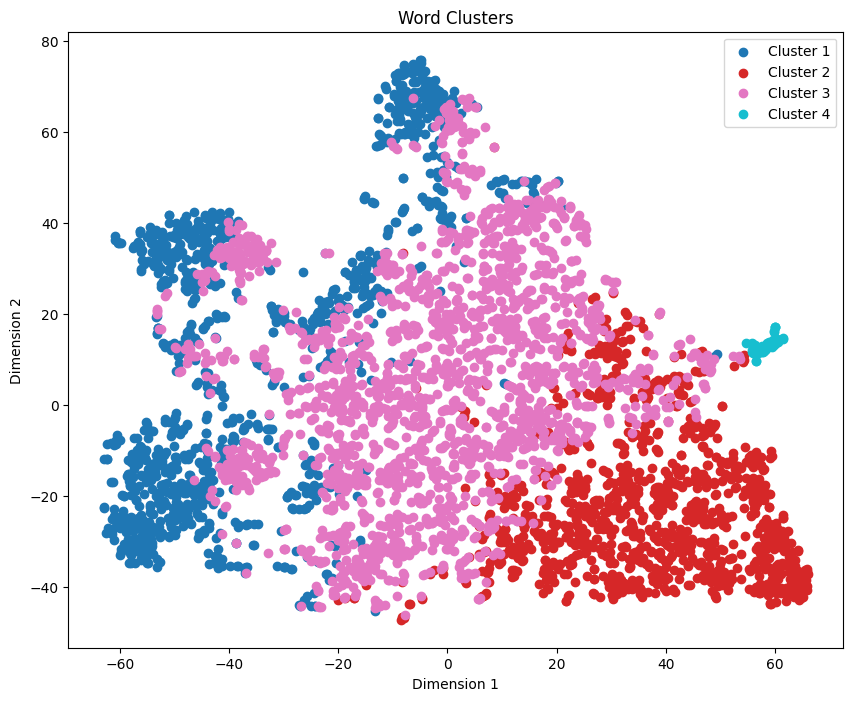

In [ ]:
# Step 6: Apply clustering algorithm
num_clusters = 4 # Number of clusters to create
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)

# Step 7: Visualize the clusters using t-SNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(word_embeddings.vectors)

# Step 8: Plot the clusters with different colors
plt.figure(figsize=(10, 8))
color_palette = plt.cm.get_cmap('tab10', num_clusters)
for i in range(num_clusters):
    cluster_embeddings = tsne_embeddings[clusters == i]
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], color=color_palette(i), label=f'Cluster {i+1}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Clusters')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-32-ccc012efb25d>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', num_clusters)


AttributeError: ignored

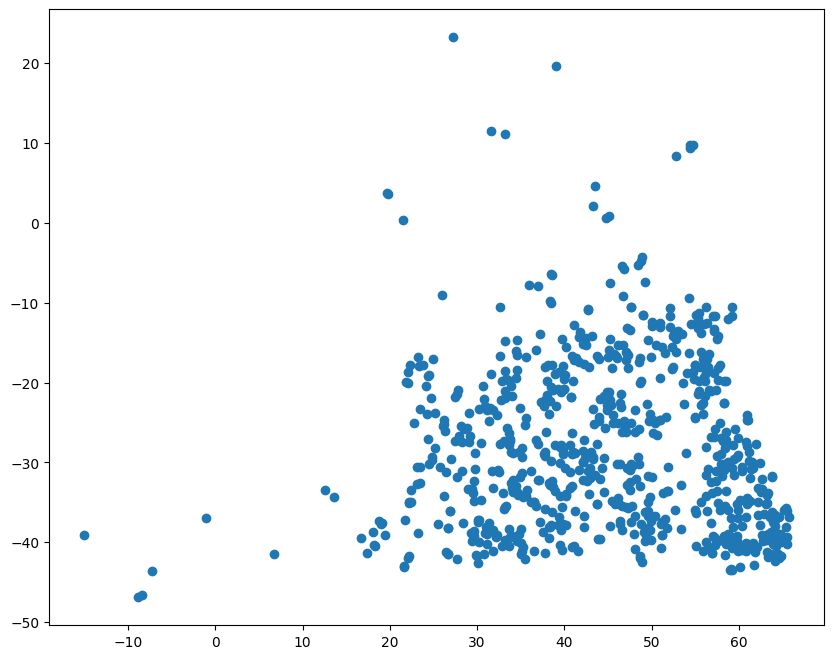

In [ ]:
# Step 6: Apply clustering algorithm
num_clusters = 5  # Number of clusters to create
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)

# Step 7: Visualize the clusters using t-SNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(word_embeddings.vectors)

# Step 8: Plot the clusters with different colors
plt.figure(figsize=(10, 8))
color_palette = plt.cm.get_cmap('tab10', num_clusters)
for i in range(num_clusters):
    cluster_embeddings = tsne_embeddings[clusters == i]
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], color=color_palette(i), label=f'Cluster {i+1}')

    # Calculate word frequency within the cluster
    cluster_words = np.array(word_embeddings.index_to_key)[clusters == i]
    word_counts = [word_embeddings.vocab[word].count for word in cluster_words]

    # Display top N frequent words within the cluster
    N = 5  # Number of top words to display
    top_words_indices = np.argsort(word_counts)[-N:]
    top_words = cluster_words[top_words_indices]

    for word, embedding in zip(top_words, cluster_embeddings[top_words_indices]):
        plt.annotate(word, embedding)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Clusters')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from gensim.models import FastText
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = beliefs['belief'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Build Word Embeddings using FastText
model = FastText(sentences=tokenized_sentences, window=5, min_count=1, workers=4)

# Step 4: Access Word Embeddings
word_embeddings = model.wv

# Step 5: Calculate similarity matrix
similarity_matrix = np.dot(word_embeddings.vectors, word_embeddings.vectors.T)

# Step 6: Apply clustering algorithm
num_clusters = 5  # Number of clusters to create
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)

# Step 7: Visualize the clusters using t-SNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(word_embeddings.vectors)

# Step 8: Plot the clusters with different colors
plt.figure(figsize=(10, 8))
color_palette = plt.cm.get_cmap('tab10', num_clusters)
for i in range(num_clusters):
    cluster_embeddings = tsne_embeddings[clusters == i]
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], color=color_palette(i), label=f'Cluster {i+1}')

    # Calculate word frequency within the cluster
    cluster_words = np.array(word_embeddings.index_to_key)[clusters == i]
    word_counts = [word_embeddings.vocab[word].count for word in cluster_words]

    # Display the most frequent words within the cluster
    N = 5  # Number of top words to display
    top_words_indices = np.argsort(word_counts)[-N:]
    top_words = cluster_words[top_words_indices]

    # Print the top words for the cluster
    print(f"Cluster {i+1}: {', '.join(top_words)}")

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Clusters')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from gensim.models import FastText
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Assuming 'text_column' is the column in your DataFrame containing the text sentences
sentences = beliefs['belief'].tolist()

# Step 1: Preprocess the text data (example using lowercase conversion)
sentences = [sentence.lower() for sentence in sentences]

# Step 2: Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Step 3: Build Word Embeddings using FastText
model = FastText(sentences=tokenized_sentences, window=5, min_count=1, workers=4)

# Step 4: Access Word Embeddings
word_embeddings = model.wv

# Step 5: Calculate similarity matrix
similarity_matrix = np.dot(word_embeddings.vectors, word_embeddings.vectors.T)

# Step 6: Apply clustering algorithm
num_clusters = 5  # Number of clusters to create
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(similarity_matrix)

# Step 7: Visualize the clusters using t-SNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(word_embeddings.vectors)

# Step 8: Plot the clusters with different colors
plt.figure(figsize=(10, 8))
color_palette = plt.cm.get_cmap('tab10', num_clusters)
for i in range(num_clusters):
    cluster_embeddings = tsne_embeddings[clusters == i]
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], color=color_palette(i), label=f'Cluster {i+1}')

    # Get the words in the cluster
    cluster_words = np.array(word_embeddings.index_to_key)[clusters == i]

    # Calculate word frequencies within the cluster
    word_counts = [model.wv.vocab[word].count for word in cluster_words]

    # Get the indices of the most frequent words
    top_words_indices = np.argsort(word_counts)[-5:]

    # Get the most frequent words within the cluster
    top_words = cluster_words[top_words_indices]

    # Print the top words for the cluster
    print(f"Cluster {i+1}: {', '.join(top_words)}")

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Clusters')
plt.legend()
plt.show()


In [ ]:
# Step 1: Get the word embeddings model
word_embeddings = model.wv

# Step 2: Get the index-to-word mapping
index_to_word = word_embeddings.index_to_key

# Step 3: Calculate word frequencies within the cluster
word_counts = [word_embeddings.get_vecattr(word, 'count') for word in cluster_words]

# Step 4: Get the indices of the most frequent words
most_frequent_indices = np.argsort(word_counts)[::-1][:num_words]

# Step 5: Get the most frequent words
most_frequent_words = [index_to_word[index] for index in most_frequent_indices]

# Step 6: Print the most frequent words
for word in most_frequent_words:
    print(word)


In [ ]:
pip install sentence_transformers

In [ ]:

# comparing the two sentences using SBERT and Cosine Similarity

# here's the install command
#!pip install -U sentence-transformers
import pandas as pd
from sentence_transformers import SentenceTransformer, util


# load our Sentence Transformers model pre trained!!
model = SentenceTransformer('all-MiniLM-L6-v2')


# as always, we will get sentences from a
# public kaggle dataset
https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format?resource=download
df = pd.read_csv('imbd_train_dataset.csv')

# while this data has lots of good info, we just need the reviews
# let's grab 2000

# in real-life, you should not clean data like this
# since this wasn't a data cleaning tutorial I didn't want to bloat
# the code

# this is not production ready data!!
sentences = [sentence.lower()\
             .replace("br","")\
             .replace('<',"")\
             .replace(">","")\
             .replace('\\',"")\
             .replace('\/',"")\
             for sentence in df.text.sample(n=2000)]

#see a sentence, and our length
print(sentences[5:6], f'\n\nLength Of Data {len(sentences)}')

In [ ]:
# lets find the semantically closest sentence to a random sentence
# that we come up with, in our dataset

# i like action movies, mission impossible is one of my favorites
our_sentence = 'I really love action movies, huge tom cruise fan!'

# lets embed our sentence
my_embedding = model.encode(our_sentence)

# lets embed the corpus
embeddings = model.encode(sentences)

#Compute cosine similarity between my sentence, and each one in the corpus
cos_sim = util.cos_sim(my_embedding, embeddings)

# lets go through our array and find our best one!
# remember, we want the highest value here (highest cosine similiarity)
winners = []
for arr in cos_sim:
    for i, each_val in enumerate(arr):
        winners.append([sentences[i],each_val])

# lets get the top 2 sentences
final_winners = sorted(winners, key=lambda x: x[1], reverse=True)



for arr in final_winners[0:2]:
    print(f'\nScore : \n\n  {arr[1]}')
    print(f'\nSentence : \n\n {arr[0]}')